# Планирование кампании интернет-магазина компьютерных игр

Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Изучение данных из файлов

In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from io import BytesIO
import requests

In [2]:
# чтение файла с данными и сохранение в df
df = pd.read_csv('games.csv')

In [3]:
# получение первых 5 строк таблицы df
df.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
# получение общей информации о данных в таблице df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
# подсчёт доли пропусков
df.isna().mean().round(decimals=2)

Name               0.00
Platform           0.00
Year_of_Release    0.02
Genre              0.00
NA_sales           0.00
EU_sales           0.00
JP_sales           0.00
Other_sales        0.00
Critic_Score       0.51
User_Score         0.40
Rating             0.40
dtype: float64

### Вывод

Таблица состоит из 11 столбцов, содержащих информацию о 16715 компьютерных играх:
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Необходима замена названий столбцов - приведение их к нижнему регистру.

В столбце Year_of_Release имеется небольшое количество пропущенных значений, в столбцах Critic_Score, User_Score и Rating значительное количество пропусков - 40-50%.

В столбцах Year_of_Release и User_Score целесообразно изменить тип данных на целочисленный и дробный соответственно.

Имеющихся данных достаточно для проведения анализа.

## Предобработка данных

Для начала приведем названия столбцов к нижнему регистру. Затем поочередно изучим значения каждого из столбцов, проведем необходимую подготовку данных.

In [6]:
#замена названий столбцов
df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### name

Столбец содержит названия игр. Тип данных object, что соответствует специфике столбца. Имеется 2 пропущенных значения, рассмотрим эти строки.

In [7]:
#получение значений столбца name
df['name'].value_counts()

Need for Speed: Most Wanted                                             12
Ratatouille                                                              9
LEGO Marvel Super Heroes                                                 9
FIFA 14                                                                  9
Madden NFL 07                                                            9
                                                                        ..
Halo: The Master Chief Collection                                        1
Mahou Sensei Negima! Private Lesson 2: Ojama Shimasu Parasite de Chu     1
Elvandia Story                                                           1
The King of Fighters Portable '94~'98: Chapter of Orochi                 1
The Mummy                                                                1
Name: name, Length: 11559, dtype: int64

Вероятнее всего повторы в названиях обусловлены выпуском одной игры на разных игровых платформах. Целесообразно провести проверку на наличие дубликатов по совокупности данных столбцов name и platform. Проведем ее после изучения и подготовки данных столбца platform.

In [8]:
#получение пропущенных значений столбца name
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Данные строки содержат мало полезной информации и большое количество пропущенных значений, заполнение которых по имеющимся данным невозможно. Удалим их.

In [9]:
#удаление строк, содержащих пропуски в столбце name
df.dropna(subset = ['name'], inplace=True)

### platform

Столбец содержит названия игровой платформы. Тип данных object, что соответствует специфике столбца. Пропущенных значений нет. Изучим данные столбца, а также проведем проверку на наличие дубликатов по совокупности данных столбцов name и platform.

In [10]:
#получение значений столбца platform
df['platform'].value_counts()

PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
GB        98
NES       98
DC        52
GEN       27
NG        12
WS         6
SCD        6
3DO        3
TG16       2
PCFX       1
GG         1
Name: platform, dtype: int64

In [11]:
#получение дублирующихся строк таблицы
dup = df[['name', 'platform']][df[['name', 'platform']].duplicated()]
dup

,name,platform
1591,Need for Speed: Most Wanted,X360
4127,Sonic the Hedgehog,PS3
11715,Need for Speed: Most Wanted,PC
16230,Madden NFL 13,PS3


In [12]:
#изучение дублирующихся строк
df.query('name == "Need for Speed: Most Wanted" & platform == "X360"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1190,Need for Speed: Most Wanted,X360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1591,Need for Speed: Most Wanted,X360,2005.0,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T


In [13]:
#изучение дублирующихся строк
df.query('name == "Need for Speed: Most Wanted" & platform == "PC"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
5972,Need for Speed: Most Wanted,PC,2005.0,Racing,0.02,0.23,0.0,0.04,82.0,8.5,T
11715,Need for Speed: Most Wanted,PC,2012.0,Racing,0.00,0.06,0.0,0.02,82.0,8.5,T


Игра Need for Speed: Most Wanted была выпущена в 2005 году и затем перезапущена в 2012. Не является дубликатом.

In [14]:
#изучение дублирующихся строк
df.query('name == "Sonic the Hedgehog" & platform == "PS3"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1745,Sonic the Hedgehog,PS3,2006.0,Platform,0.41,0.06,0.04,0.66,43.0,4.1,E10+
4127,Sonic the Hedgehog,PS3,NaN,Platform,0.00,0.48,0.00,0.00,43.0,4.1,E10+


Удалим дубликат строки. Для исключения потери данных просуммируем значение столбца eu_sales.

In [15]:
#удаление дубликатов
df.loc[1745, 'eu_sales'] = 0.54
df = df.drop([4127])

In [16]:
#изучение дублирующихся строк
df.query('name == "Madden NFL 13" & platform == "PS3"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


Удалим дубликат строки. Значение в столбце eu_sales (строка 16230) минимальное по столбцу. Объясним его наличие погрешностью заполнения данных. В этой связи переносить его в строку 604 не будем.

In [17]:
#удаление дубликатов
df = df.drop([16230])

### year_of_release

Столбец содержит год выхода игры. Тип данных float, целесообразно заменить на int. Имеются пропущенные значения. Изучим их.

In [18]:
#получение строк с пропусками в столбце year_of_release
year_nan = df[df['year_of_release'].isna()]
year_nan

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Количество строк с пропусками в столбце - 268. Учитывая их небольшое количество, а также важность данного столбца для последующего анализа, заполним их путем двухчасового гуглежа [ ± _ ± ]. Подготовку недостающих данных я провела в Excel, воспользовавшись для работы столбцами name и platform таблицы year_nan.
Прочтем файл с получившимися данными.

In [19]:
# чтение файла с данными и сохранение в df_year
spreadsheet_id = '1lCJ7hdL_7y9ATVq9IkuE4ijHf6kYdfXErcBcm6bYuoQ'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
df_year = pd.read_csv(BytesIO(r.content))
df_year = df_year.dropna()
df_year

,Unnamed: 0,name,platform,year_of_release
0,183.0,Madden NFL 2004,PS2,2003.0
1,377.0,FIFA Soccer 2004,PS2,2004.0
2,456.0,LEGO Batman: The Videogame,Wii,2008.0
3,475.0,wwe Smackdown vs. Raw 2006,PS2,2005.0
4,609.0,Space Invaders,2600,1980.0
...,...,...,...,...
263,16373.0,PDC World Championship Darts 2008,PSP,2008.0
264,16405.0,Freaky Flyers,GC,2003.0
265,16448.0,Inversion,PC,2012.0
266,16458.0,Hakuouki: Shinsengumi Kitan,PS3,2014.0


In [20]:
#назначение первого столбца индексом
df_year = df_year.set_index('Unnamed: 0')

Добавим в таблицу df столбец year, заполним его значениями из получившейся таблицы df_year. Заполним пропущенные значения в столбце year_of_release значениями столбца year. Изменим тип данных на целочисленный.

In [21]:
#добавление в таблицу df столбца таблицы df_year
df['year'] = df_year['year_of_release']

In [22]:
#заполнение пропущенных значений в столбце year_of_release
df['year_of_release'] = df['year_of_release'].fillna(df['year'])

In [23]:
#замена типа данных
df['year_of_release'] = df['year_of_release'].astype('int')

В ходе сбора недостающих данных была выявлена игра Brothers in Arms: Furious 4, которая изначально планировалась к выходу в 2012 году, позже выход переносился, в 2015 году стало известно о том, что разработка отменена. Изучим имеющиеся по ней данные.

In [24]:
#получение строки, соответствующей условию
df.query('name == "Brothers in Arms: Furious 4"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,year
12185,Brothers in Arms: Furious 4,PS3,2012,Shooter,0.01,0.05,0.0,0.01,NaN,NaN,M,NaN
16329,Brothers in Arms: Furious 4,X360,0,Shooter,0.01,0.00,0.0,0.00,NaN,NaN,M,0.0


Игра Brothers in Arms: Furious 4 представлена в двух вариантах, причем год ее выхода в строке 12185 уже был заполнен в исходных данных. Учитавя имеющуюся информацию, будем считать данные в строке 12185 неблагонадежными. Удалим обе строки.

In [25]:
#удаление строк
df = df.drop([12185])
df = df.drop([16329])

Не найдено информации об игре Housekeeping (строка 14126). Изучим имеющиеся по ней данные.

In [26]:
#получение строки, соответствующей условию
df.query('name == "Housekeeping"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,year
14126,Housekeeping,DS,0,Action,0.0,0.0,0.04,0.0,NaN,NaN,NaN,0.0


In [27]:
#удаление строк
df = df.drop([14126])

In [28]:
#получение значений столбца year_of_release
df['year_of_release'].min(), df['year_of_release'].max()

(1977, 2018)

Следует отметить, что после дозаполнения исходных данных диапазон значений столбца year_of_release увеличился: добавились данные за 2018 год. Это может быть связано с тем, что на момент выгрузки исходных данных (2016 год) некоторые игры были проанонсированы но еще не выпущены. При проведении исследования такие данные учитываться не будут.

### genre

Столбец содержит жанры игр. Тип данных соответствует специфике столбца. Имелось два пропущенных значения, строки с которыми были удалены в подразделе 2.1 данной работы. Изучим значения столбца.

In [29]:
#получение значений столбца
df['genre'].value_counts()

Action          3368
Sports          2347
Misc            1750
Role-Playing    1498
Shooter         1321
Adventure       1303
Racing          1249
Platform         887
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: genre, dtype: int64

### na_sales, eu_sales,  jp_sales, other_sales

Столбцы na_sales, eu_sales, jp_sales, other_sales содержат сведения о количестве проданных копий игр (в млн) в Северной Америке, Европе, Японии и других странах соответственно. Пропущенных значений нет. Тип данных соответствует специфике столбцов. Изучим подробнее значения столбцов.

In [30]:
#создание описательной статистики столбцов na_sales, eu_sales, jp_sales, other_sales
df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].describe()

,na_sales,eu_sales,jp_sales,other_sales
count,16708.000000,16708.000000,16708.000000,16708.000000
mean,0.263380,0.145085,0.077645,0.047356
std,0.813674,0.503432,0.308915,0.186768
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.080000,0.020000,0.000000,0.010000
75%,0.240000,0.110000,0.040000,0.030000
max,41.360000,28.960000,10.220000,10.570000


Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец total_sales

In [31]:
#добавление столбца с результатом расчетов
df = df.rename(columns={'year':'total_sales'})
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52


In [32]:
#создание описательной статистики столбца total_sales
df['total_sales'].describe()

count    16708.000000
mean         0.533467
std          1.548511
min          0.000000
25%          0.060000
50%          0.170000
75%          0.470000
max         82.540000
Name: total_sales, dtype: float64

### critic_score

В столбце содержатся данные об оценке критиков (максимум 100). Тип данных соответствует специфике столбца. Имеется значительное количество пропущенных значений (51%). Учитывая то, что исходные данные были получены из открытых источников, пропуски в них, вероятно, обусловлены отсутствием информации. Целесообразно заменить пропущенные значения на 0. Произведем замену. Изучим стат информацию по имеющимся данным.

In [33]:
#создание описательной статистики столбца critic_score
df['critic_score'].describe()

count    8135.000000
mean       68.969146
std        13.936036
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

In [34]:
#замена пропущенных значений 0
df['critic_score'] = df['critic_score'].fillna(0)

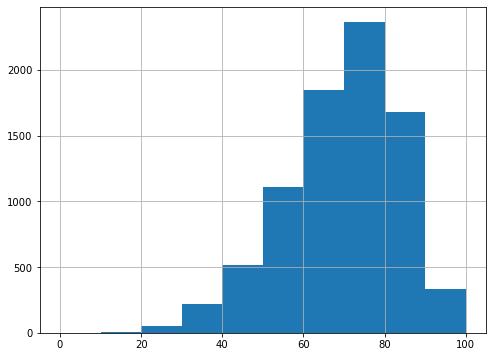

In [35]:
#построение гистограммы
df.query('critic_score !=0')['critic_score'].hist(bins=[0,10,20,30,40,50,60,70,80,90,100], figsize=(8, 6));

### user_score

В столбце содержатся данные об оценке пользователей (максимум 10). Тип данных (object) не соответствует специфике столбца. Необходимо изучение значений столбца. Имеется значительное количество пропущенных значений (40%). Учитывая то, что исходные данные были получены из открытых источников, пропуски в них, вероятно, обусловлены отсутствием информации. Целесообразно заменить пропущенные значения на 0.

In [36]:
#замена пропущенных значений 0
df['user_score'] = df['user_score'].fillna(0)

In [37]:
#получение значений столбца user_score
df['user_score'].value_counts()

0      6696
tbd    2424
7.8     324
8       290
8.2     282
       ... 
9.6       2
0.3       2
1         2
9.7       1
0         1
Name: user_score, Length: 97, dtype: int64

В столбце содержится 2424 значение tbd (14,5% от общего цисла), это аббревиатура от 'To Be Determined', те рейтинг не определен. Такое обозначение тяготеет к малопопулярным играм, имеющим недостаточное для оценки количество отзывов. Целесообразно заменить на 0. Затем произведем изменение типа данных в столбце.

In [38]:
# замена значений tbd на 0
df['user_score'] = df['user_score'].replace('tbd','0')

In [39]:
#замена типа данных
df['user_score'] = df['user_score'].astype('float')

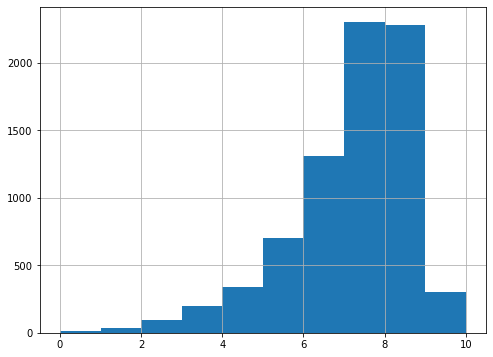

In [40]:
#построение гистограммы
df.query('user_score !=0')['user_score'].hist(bins=[0,1,2,3,4,5,6,7,8,9,10], figsize=(8, 6));

### rating

В столбце содержатся данные о рейтинге игр от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию. Тип данных соответствует специфике столбца. Имеется значительное количество пропущенных значений (40%). Учитывая то, что исходные данные были получены из открытых источников, пропуски в них, вероятно, обусловлены отсутствием информации. Для выявления других возможных проблем изучим имеющиеся категории.

In [41]:
#получение значений столбца
df['rating'].value_counts()

E       3989
T       2961
M       1561
E10+    1419
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

Расшифруем имеющиеся категории: 
- «EC» («Early childhood») — для детей младшего возраста,
- «E» («Everyone») — для всех,
- «E10+» («Everyone 10 and older») — для всех старше 10 лет,
- «T» («Teen») — подросткам,
- «M» («Mature») — от 17 лет,
- «AO» («Adults Only 18+») — только для взрослых,
- «RP» («Rating Pending») — рейтинг ожидается (продукт был отправлен в ESRB и ожидает присвоения рейтинга, данный логотип используется только на рекламных презентациях и в демо-версиях игр до официального релиза)
- «K-A» («Kids to Adults»)— «Для детей и взрослых» (устаревшее, был заменён на «Everyone»)

Целесообразно заменить K-A на Everyone, а RP на unknown. 

Многие игры выпускаются на разных игровых платформах, повторяясь названием в исходных данных. Рейтинг игры при этом от платформы не зависит и не меняется. Учитывая это заполним часть пропусков значениями других строк таблицы в границах одного названия.

Остальные пропущенные значения заменим на unknown.

In [42]:
#замена значений столбца
df['rating'] = df['rating'].replace('K-A','E')
df['rating'] = df['rating'].replace('RP','unknown')

In [43]:
#заполнение пропусков значениями других подходящих строк
df['rating'] = df.groupby(['name'], sort=False)['rating'].apply(lambda x: x.ffill().bfill())

In [44]:
#заполнение пропущенных значений столбца
df['rating'] = df['rating'].fillna('unknown')

In [45]:
#получение значений столбца
df['rating'].value_counts()

unknown    6329
E          4156
T          3090
M          1651
E10+       1471
EC           10
AO            1
Name: rating, dtype: int64

### Вывод

Проведена необходимая предобработка данных. Названия столбцов приведены к нижнему регистру. Удалено 7 строк таблицы в связи с недостаточным наполнением или дублированием информации. В столбцах year_of_release, critic_score, user_score и rating проведено заполнение пропущенных значений. Добавлен столбец total_sales, содержащий суммарные продажи во всех регионах. В столбцах year_of_release и user_score изменен тип данных.

In [46]:
# получение общей информации о данных в таблице df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16708 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16708 non-null  object 
 1   platform         16708 non-null  object 
 2   year_of_release  16708 non-null  int32  
 3   genre            16708 non-null  object 
 4   na_sales         16708 non-null  float64
 5   eu_sales         16708 non-null  float64
 6   jp_sales         16708 non-null  float64
 7   other_sales      16708 non-null  float64
 8   critic_score     16708 non-null  float64
 9   user_score       16708 non-null  float64
 10  rating           16708 non-null  object 
 11  total_sales      16708 non-null  float64
dtypes: float64(7), int32(1), object(4)
memory usage: 1.6+ MB


## Исследовательский анализ данных

### Общая динамика выпуска игр

Определим сколько игр выпускалось в разные годы и выявим актуальный для проведения исследования период. Для этого сформируем сводную таблицу, содержащую данные о количестве выпущенных игр в разрезе каждого года, по полученным данным построим столбчатую диаграмму.

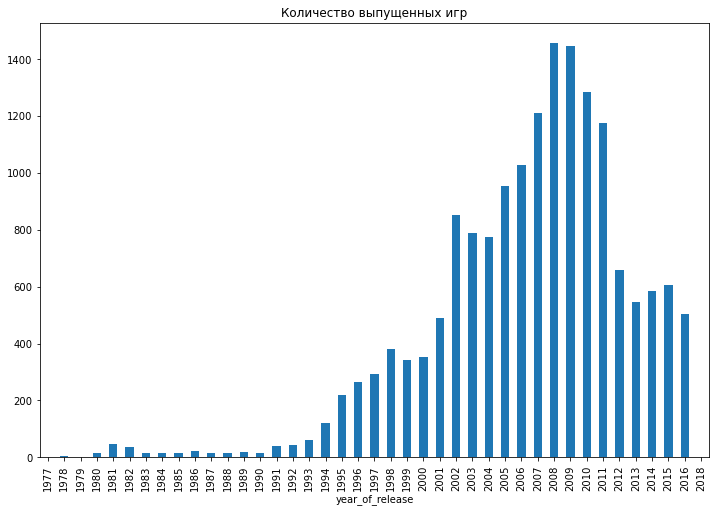

In [47]:
#построение диаграммы
df.pivot_table(index='year_of_release', values='name', aggfunc='count').plot(kind='bar', y='name', legend=False,
                                                                                            figsize=(12, 8), 
                                                                                            title='Количество выпущенных игр');

Развитие рынка видеоигр тесно связано с производительностью и возможностями компьютерного оборудования. На гистограмме виден слабоактивный период с 1977 по 1995 год, затем плавное увеличение количества выпускаемых игр в период до 2001 года, затем с 2002 года - резкий скачкообразый рост игровой индустрии.

Подготовка исходных данных производилась в 2016 году, они могут быть неполными. 

В данной связи актуальным для проведения исследования будем считать период с 1995 по 2015 годы. Сохраним данные в пределах этого периода в таблицу df_actual.

In [48]:
#сохранение данных в пределах актуального периода
df_actual = df.query('1995 <= year_of_release <= 2016')

### Динамика выпуска игр по платформам

Определим среднюю длительность жизненного цикла игровых платформ. Для начала определим самые прибыльные платформы. Построим столбчатую диаграмму, отражающую общее количество проданных копий игр отностительно каждой плаформы.

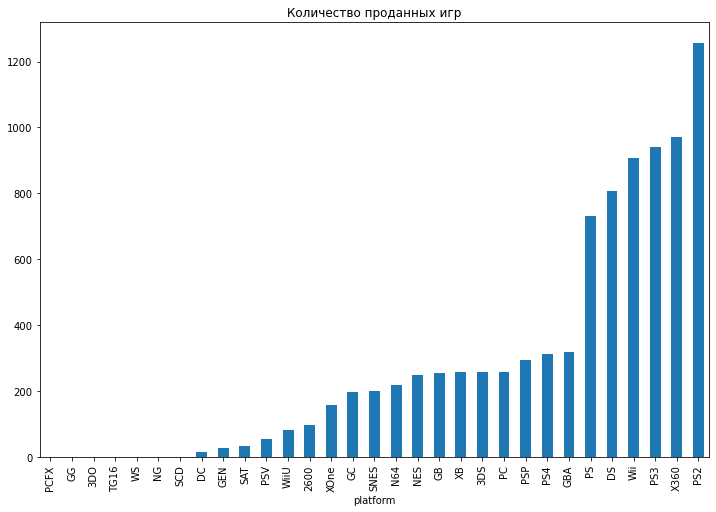

In [49]:
#построение столбчатой диаграммы
df.groupby('platform')['total_sales'].sum().sort_values().plot(kind='bar', figsize=(12, 8), 
                                                                title='Количество проданных игр');

<a id='3.2'></a>
На гистограмме явно лидируют следующие платформы:
- PS
- DS
- Wii
- PS3
- X360
- PS2

Сохраним их в список top_platforms. Подготовим сводную таблицу, отражающую количество проданных копий игр, разработанных на популярных игровых платформах, отностительно года их выпуска. Построим диаграмму по полученным данным.

In [50]:
#подготовка сводной таблицы
top_platforms = ["PS", "DS", "Wii", "PS3", "X360", "PS2"]

index = range(1994, 2018)
agg_platform = pd.DataFrame(index=index)
for elem in top_platforms:
    agg_platform[elem] = df[df['platform'] == elem].pivot_table(index='year_of_release', values='platform', aggfunc='count')
    agg_platform[elem] = agg_platform[elem].fillna(0)
agg_platform.head()

,PS,DS,Wii,PS3,X360,PS2
1994,17.0,0.0,0.0,0.0,0.0,0.0
1995,99.0,0.0,0.0,0.0,0.0,0.0
1996,164.0,0.0,0.0,0.0,0.0,0.0
1997,188.0,0.0,0.0,0.0,0.0,0.0
1998,250.0,0.0,0.0,0.0,0.0,0.0


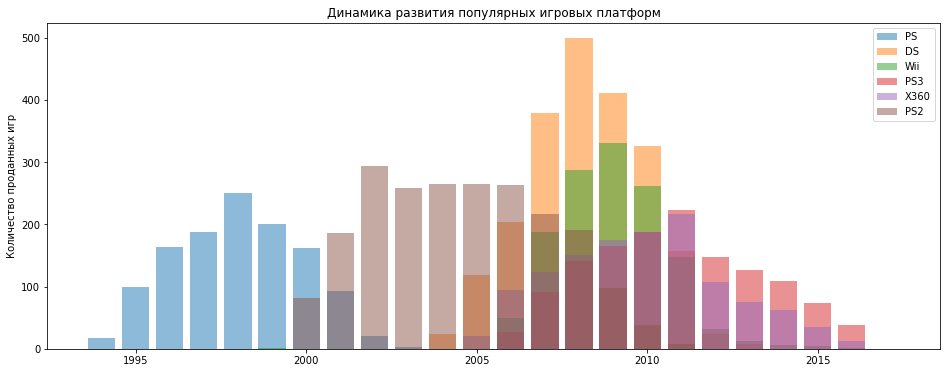

In [51]:
#построение столбчатой диаграммы
fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(6)

for ever_platform in top_platforms:
    ax.bar(agg_platform.index, agg_platform[ever_platform], alpha=0.5, label=ever_platform)
ax.legend()
plt.title('Динамика развития популярных игровых платформ')
plt.ylabel('Количество проданных игр');

На диаграмме каждой цветной волной изображен жизненный цикл одной из популярных игровых платформ. Явно прослеживается общая для всех платформ динамика: период активного роста с максимумом популярности к 5му году, затем такое же стремительное затухание. Средняя длительность потребительской актуальности каждой игровой платформы - 10 лет. Проверим справедливость выявленной закономерности для всех игровых платформ, используем данные только актуального периода(2002-2015гг). Для этого построим сводную таблицу.

In [52]:
#подготовка сводной таблицы
all_platforms = df.query('2002 <= year_of_release <= 2016')['platform'].unique().tolist()

index = range(2002, 2017)
agg_all_platforms = pd.DataFrame(index=index)

for elem in all_platforms:
    agg_all_platforms[elem] = df[df['platform'] == elem].pivot_table(index='year_of_release', values='platform', aggfunc='count')
    agg_all_platforms[elem] = agg_all_platforms[elem].fillna(0)

agg_all_platforms.style
cm = sns.light_palette("Orange", as_cmap=True)
agg_all_platforms.style.background_gradient(cmap=cm)

,Wii,DS,X360,PS3,PS2,GBA,PS4,3DS,XB,PC,PSP,XOne,WiiU,GC,PS,PSV,DC,N64
2002,0.000000,0.000000,0.000000,0.000000,293.000000,199.000000,0.000000,0.000000,165.000000,19,0.000000,0.000000,0.000000,155.000000,20.000000,0.000000,1.000000,1.000000
2003,0.000000,0.000000,0.000000,0.000000,258.000000,151.000000,0.000000,0.000000,191.000000,33,0.000000,0.000000,0.000000,151.000000,3.000000,0.000000,0.000000,0.000000
2004,0.000000,23.000000,0.000000,0.000000,264.000000,178.000000,0.000000,0.000000,181.000000,30,15.000000,0.000000,0.000000,84.000000,0.000000,0.000000,0.000000,0.000000
2005,0.000000,119.000000,20.000000,0.000000,265.000000,139.000000,0.000000,0.000000,182.000000,37,95.000000,0.000000,0.000000,98.000000,0.000000,0.000000,0.000000,0.000000
2006,50.000000,204.000000,95.000000,27.000000,263.000000,39.000000,0.000000,0.000000,63.000000,52,192.000000,0.000000,0.000000,41.000000,0.000000,0.000000,0.000000,0.000000
2007,188.000000,379.000000,124.000000,92.000000,217.000000,6.000000,0.000000,0.000000,3.000000,62,134.000000,0.000000,0.000000,4.000000,0.000000,0.000000,1.000000,0.000000
2008,287.000000,499.000000,150.000000,141.000000,191.000000,0.000000,0.000000,0.000000,2.000000,78,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
2009,330.000000,411.000000,175.000000,165.000000,97.000000,0.000000,0.000000,0.000000,0.000000,107,161.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010,262.000000,325.000000,188.000000,187.000000,38.000000,0.000000,0.000000,1.000000,0.000000,93,190.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011,147.000000,157.000000,216.000000,223.000000,7.000000,0.000000,0.000000,121.000000,0.000000,144,142.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000,0.000000


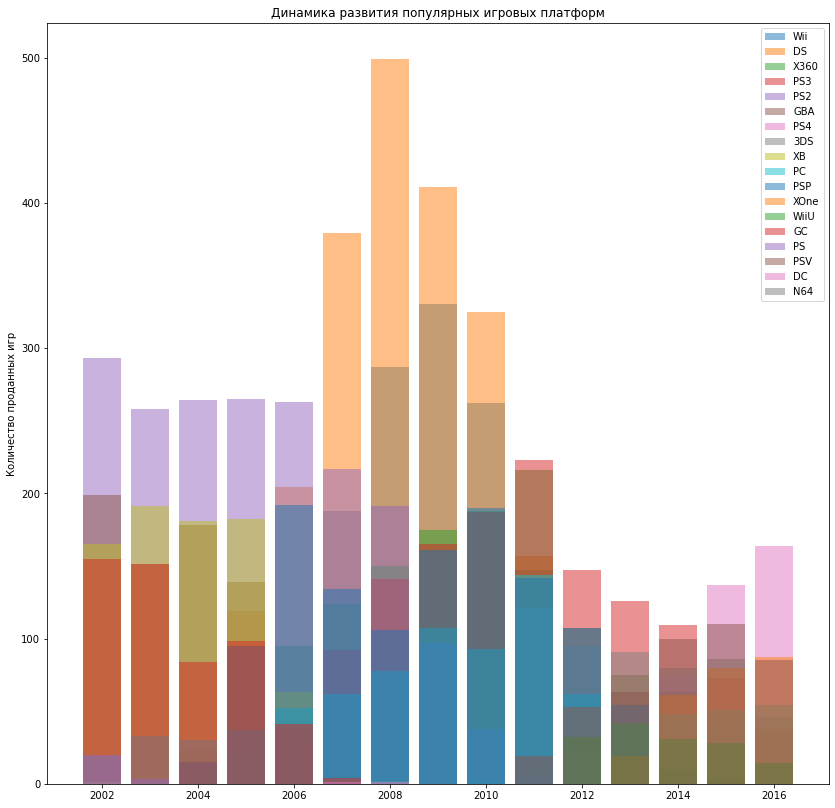

In [53]:
#построение столбчатой диаграммы
fig, ax = plt.subplots()
fig.set_figwidth(14)
fig.set_figheight(14)

for ever_platform in all_platforms:
    ax.bar(agg_all_platforms.index, agg_all_platforms[ever_platform], alpha=0.5, label=ever_platform)
ax.legend()
plt.title('Динамика развития популярных игровых платформ')
plt.ylabel('Количество проданных игр');

В сводной таблице уровень цветовой насыщенности соответствует популярности каждой из платформы, те чем ярче цвет, тем больше популярность.

Действительно подтверждается вывод о потребительской актуальности каждой игровой платформы длительностью 10 лет с максимумом популярности в середине жизненного процесса. Каждая игровая платформа переживает период развития (насыщенность цвета в соответствующем платформе столбце усиливается сверху вниз) и затем угасание (насыщенность цвета понижается от года к году).

Можно отметить молодые игровые платформы, которые в ближайшие годы вероятно будут занимать лидирующие позиции на рынке компьютерных игр (их ярко окрашенный жизненный цикл тяготеет к нижней границе таблицы):
- PS4
- XOne

Вступают в фазу спада активности:
- WiiU
- PSV
- 3DS

Прочие игровые платформы будем считать устаревшими.

Учитывая длительность периода потребительской актуальности игровых платформ - 10 лет, определять перспективы дальнейшего развития магазина целесообразно, основываясь на данных последних 10 - 15 лет. Сократим актуальный для исследования период с 1995-2015 до 2002-2016 гг.

In [54]:
#уточнение актуального периода
df_actual = df_actual.query('2002 <= year_of_release <= 2016')

### Объемы продаж игр на популярных платформах

Построим диаграмму размаха по глобальным продажам игр в разбивке по наиболее популярным платформам.

Популярные платформы были определены в подразделе [3.2](#3.2) (это PS, DS, Wii, PS3, X360, PS2), но для корректного анализа нам необходимы только те из них, развитие которых происходило в пределах актуального периода (df_actual), это:
- DS
- Wii
- PS3
- X360
- PS2
 
По этим платформам имеется большое количество наблюдений, это повысит качество исследования.

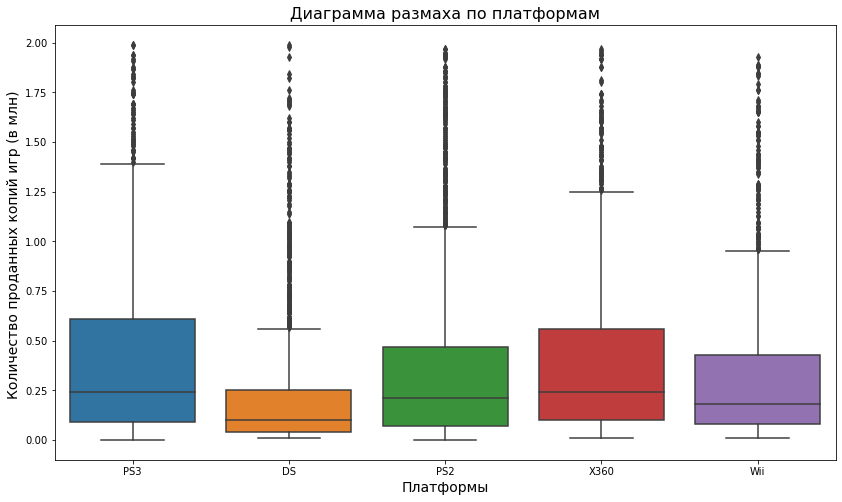

In [55]:
#построение диаграммы размаха
top_actual_platforms = ["PS3", "X360", "PS2", "DS", "Wii"]
plt.figure(figsize=(14, 8))
platform_sales = df_actual.query('platform == @top_actual_platforms & total_sales < 2')
ax = sns.boxplot(x="platform", y="total_sales", data=platform_sales)
ax.axes.set_title("Диаграмма размаха по платформам", fontsize=16)
ax.set_xlabel("Платформы", fontsize=14)
ax.set_ylabel("Количество проданных копий игр (в млн) ", fontsize=14);

Каждая диаграмма размаха отражает количество проданных копий игр (в млн) в разрезе одной из популярных платформ.

В целом все платформы имеют схожую картину разброса значений. Данные плотно сгруппированы в начале диапазона. Абсолютное большинство игр продается тиражом менее 1 млн. Игры, продажи которых превысили 5 млн экземпляров, можно считать сверх популярными, более 20 млн - звезды игровой индустрии (таких всего 20). Самая же популярная игра разошлась тиражом более 80 млн копий (платформа Wii). 

In [56]:
#рекордсмен по количетву продаж
df.query('total_sales > 80').sort_values(by = 'total_sales', ascending = False)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54


Изучим подробнее продажи игр на платформе Wii (матери рекордсмена).
Посмотрим, как влияют на продажи отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. Для более качественного анализа избавимся от выбросов - количество продаж более 1 млн и отценка пользователей и критиков не равная 0 (это пропущенные значения).

'Коэффициент корреляции 0.1860587218497426'

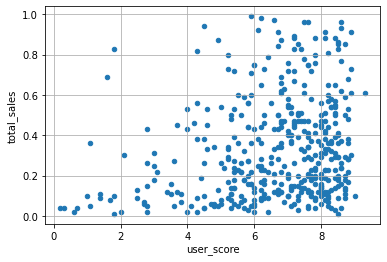

In [57]:
#расчет корреляции и построение диаграммы: отзывы пользователей
Wii = df_actual[df_actual['platform'] == 'Wii']
display(f'Коэффициент корреляции {Wii["user_score"].corr(Wii["total_sales"])}')
Wii.query('total_sales < 1 & user_score != 0.0').plot(x='user_score', y='total_sales', kind='scatter', grid=True);

Между количеством продаж и отзывом пользователей наблюдается слабая положительная корреляция (увеличение одного показателя приводит к росту другого).

'Коэффициент корреляции 0.1894192872702815'

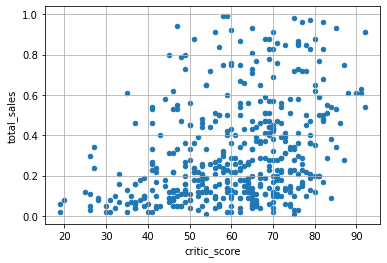

In [58]:
#расчет корреляции и построение диаграммы: отзывы критиков
Wii = df_actual[df_actual['platform'] == 'Wii']
display(f'Коэффициент корреляции {Wii["critic_score"].corr(Wii["total_sales"])}')
Wii.query('total_sales < 1 & critic_score != 0.0').plot(x='critic_score', y='total_sales', kind='scatter', grid=True);

Между количеством продаж и отзывом критиков наблюдается слабая положительная корреляция (увеличение одного показателя приводит к росту другого). 

Взаимосвязь между объемами продаж и отзывами критиков чуть сильнее, чем между объемами продаж и отзывами пользователей.

Изучим взаимосвязь между количеством продаж и отзывами для других популярных игровых платформ. Для этого создадим соответствующую функцию и поочередно применим ее к платформам DS, PS2, X360 и PS3.

In [59]:
#создание функции для расчет корреляции и построение диаграммы
def corr_score(data, platform_name):
    platform_name = data[data['platform'] == platform_name]
    display(f'Коэффициент корреляции между объемами продаж и отзывами пользователей {platform_name["user_score"].corr(platform_name["total_sales"])}')
    platform_name.query('total_sales < 1 & user_score != 0.0').plot(x='user_score', y='total_sales', kind='scatter', grid=True);
    display(f'Коэффициент корреляции между объемами продаж и отзывами критиков {platform_name["critic_score"].corr(platform_name["total_sales"])}')
    platform_name.query('total_sales < 1 & critic_score != 0.0').plot(x='critic_score', y='total_sales', kind='scatter', grid=True);

'Коэффициент корреляции между объемами продаж и отзывами пользователей 0.18773793361998475'

'Коэффициент корреляции между объемами продаж и отзывами критиков 0.15897233995625037'

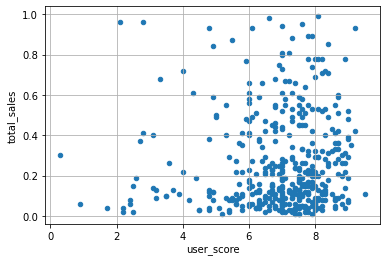

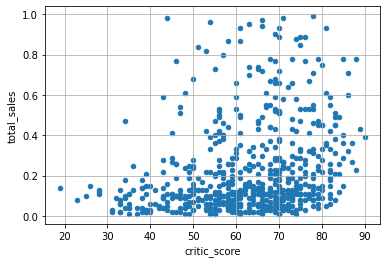

In [60]:
#расчет корреляции и построение диаграммы для платформы DS
corr_score(df_actual, 'DS')

'Коэффициент корреляции между объемами продаж и отзывами пользователей 0.2616028068369956'

'Коэффициент корреляции между объемами продаж и отзывами критиков 0.2999615447520744'

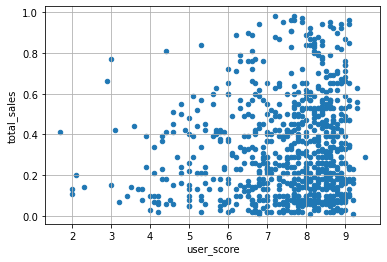

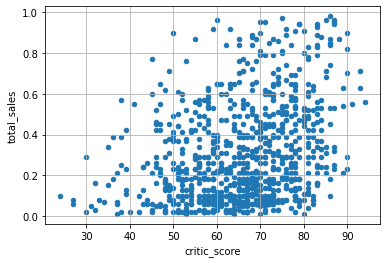

In [61]:
#расчет корреляции и построение диаграммы для платформы PS2
corr_score(df_actual, 'PS2')

'Коэффициент корреляции между объемами продаж и отзывами пользователей 0.20852800163688617'

'Коэффициент корреляции между объемами продаж и отзывами критиков 0.311542383300984'

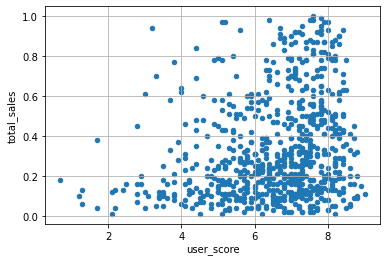

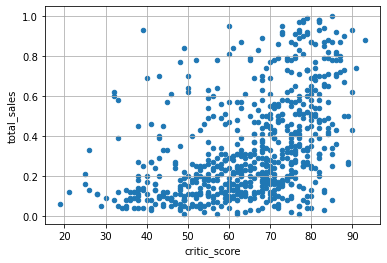

In [62]:
#расчет корреляции и построение диаграммы для платформы X360
corr_score(df_actual, 'X360')

'Коэффициент корреляции между объемами продаж и отзывами пользователей 0.27385793763087596'

'Коэффициент корреляции между объемами продаж и отзывами критиков 0.3554369211864697'

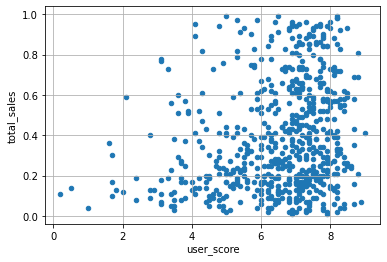

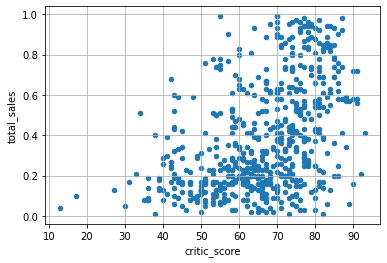

In [63]:
#расчет корреляции и построение диаграммы для платформы PS3
corr_score(df_actual, 'PS3')

Общая картина зависимости количества продаж от отзывов критиков и пользователей, выявленная для игр платформы Wii, характерна и для других платформ: между количеством продаж и отзывом наблюдается слабая положительная корреляция (увеличение одного показателя приводит к росту другого), взаимосвязь между объемами продаж и отзывами критиков чуть сильнее, чем между объемами продаж и отзывами пользователей.

Не типично:
- для платформы DS корреляция между продажами и отзывами критиков ниже чем корреляция между продажами и отзывами игроков, а также она ниже чем на других платформах
- для платформы PS3 корреляция между продажами и отзывами критиков выше чем на других платформах

### Распределение игр по жанрам

Посмотрим на общее распределение игр по жанрам. Для этого создадим сводную таблицу df_genre.

In [64]:
#создание сводной таблицы: жанры
df_genre = df_actual.groupby(['genre']).agg({'total_sales': ['mean', 'count', 'sum']})
df_genre.columns = ["_".join(a) for a in df_genre.columns.to_flat_index()]
df_genre.sort_values(by = 'total_sales_sum', ascending = False, inplace = True)
df_genre

,total_sales_mean,total_sales_count,total_sales_sum
genre,,,
Action,0.482282,3019,1456.01
Sports,0.575272,1838,1057.35
Shooter,0.810730,1096,888.56
Misc,0.442123,1578,697.67
Role-Playing,0.548395,1246,683.30
Racing,0.521182,939,489.39
Platform,0.666006,661,440.23
Simulation,0.424486,740,314.12
Fighting,0.460166,604,277.94


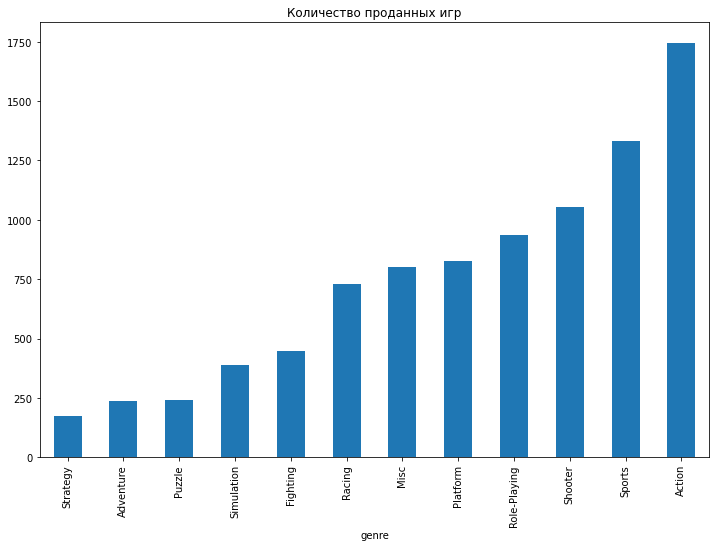

In [65]:
#построение диаграммы для наглядности
df.groupby('genre')['total_sales'].sum().sort_values().plot(kind='bar', figsize=(12, 8), 
                                                                title='Количество проданных игр');

Абсолютными лидерами по популярности являются игры жанра Action, их больше прочих выпускают и чаще других покупают. За ними по количеству игр и объемам продаж следуют игры жанра Sports. 

Игры жанра Shooter можно назвать самыми прибыльными, они имеют наибольший показатель отношения количества продаж к количеству выпускаемых игр - 0,81.

Наименее прибыльными являются игры жанров Adventure и Strategy, показатель отношения количества продаж к количеству выпускаемых игр для них - 0,15 и 0,19 соответственно.

### Вывод

В результате проведения исследовательского анализа данных выявлено следующее:
- развитие рынка видеоигр тесно связано с производительностью и возможностями компьютерного оборудования. Этим обусловлен выбор актуального для исследования периода - с 2002 по 2015 годы, а также короткий жизненный цикл игровых платформ - около 10 лет, с максимумом популярности к 5му году после выпуска. 
- на момент исследования наибольшей популярностью пользовались платформы PS2, X360, Wii, однако при планировании кампании на будующее следует отдавать предпочтение молодым платформам, которые еще только набирают популярность - PS4 и XOne.
- абсолютное большинство игр продается тиражом менее 1 млн. Игры, продажи которых превысили 5 млн экземпляров, можно считать сверх популярными.
- между количеством продаж и отзывами наблюдается слабая положительная корреляция (увеличение одного показателя приводит к росту другого), взаимосвязь между объемами продаж и отзывами критиков чуть сильнее, чем между объемами продаж и отзывами пользователей.
- самыми популярными являются игры жанра Action и Sports, а самыми прибыльными -  жанра Shooter.

## Портрет пользователя каждого региона

Составим портрет пользователя для каждого региона: для Северной Америки, для Европы и для Японии

### Портрет пользователя Северной Америки

Определим самые популярные игровые платформы среди игроков, проживающих на территории Северной Америки. Для этого создадим сводную таблицу na_df_platform.

In [66]:
#формирование сводной таблицы: платформы
na_df_platform = df_actual.groupby(['platform']).agg({'na_sales': ['count', 'sum']})

In [67]:
#создание функции для форматирования сводной таблицы
def pattern_table (data):
    data.columns = ["_".join(a) for a in data.columns.to_flat_index()]
    data.columns = ['count', 'sum']
    data['share'] = data['sum'] / data['sum'].sum() * 100
    data.sort_values(by = 'share', ascending = False, inplace = True)
    data['share'] = data['share'].round(decimals=2)
    return data

In [68]:
#вывод сводной таблицы: платформы
na_df_platform = pattern_table(na_df_platform)
na_df_platform.head()

,count,sum,share
platform,,,
X360,1261,602.46,18.23
Wii,1319,496.86,15.04
PS2,1893,488.08,14.77
PS3,1328,393.48,11.91
DS,2149,382.40,11.57


Распределение игровых платформ по популярности в Северной Америке повторяет общемировые тенденции. Пятерка лидеров та же, но расположены они в ином порядке: 
- на первом месте по популярности - X360, ее доля участия в игровой индустрии региона 18,23% от общего количества проданных игр
- на втором месте - Wii с долей участия 15,04%
- на третьем - PS2 с долей участия 14.77%
- замыкают пятерку PS3 и DS, их доли участия - 11,91% и 11,57% соответственно.

Определим самые популярные среди игроков, проживающих на территории Северной Америки, жанры игр. Для этого создадим сводную таблицу na_df_genre.

In [69]:
#определение популярных жанров
na_df_genre = df_actual.groupby(['genre']).agg({'na_sales': ['count', 'sum']})
na_df_genre = pattern_table(na_df_genre)
na_df_genre.head()

,count,sum,share
genre,,,
Action,3019,716.91,21.70
Sports,1838,549.54,16.63
Shooter,1096,480.24,14.53
Misc,1578,355.06,10.75
Role-Playing,1246,268.41,8.12


Распределение игровых жанров по популярности в Северной Америке повторяет общемировые тенденции: 
- на первом месте по популярности - Action, его доля участия в игровой индустрии региона 21,70% от общего количества проданных игр
- на втором месте - Sports	с долей участия 16,63%
- на третьем - Shooter с долей участия 14.53%
- замыкают пятерку Misc и Role-Playing, их доли участия - 10,75% и 8,12% соответственно.

Определим влияет ли рейтинг ESRB на продажи в регионе. Для этого создадим сводную таблицу na_df_rating.

In [70]:
#определение зависимости продаж от рейтинга
na_df_rating = df_actual.groupby(['rating']).agg({'na_sales': ['count', 'sum']})
na_df_rating = pattern_table(na_df_rating)
na_df_rating

,count,sum,share
rating,,,
E,3757,1173.24,35.51
M,1585,719.01,21.76
T,2851,673.08,20.37
unknown,4202,375.93,11.38
E10+,1459,359.85,10.89
EC,10,2.04,0.06
AO,1,1.26,0.04


Лучше всего продаются игры с рейтингом «Everyone». Также пользуются большой популярностью игры с рейтингами «Mature» (от 17 лет) и «Teen». Не пользуются особой популярностью, но имеют свою нишу игры для взрослых («Adults Only 18+») и игры для малышей («Early childhood»).

### Портрет пользователя Европы

Определим самые популярные игровые платформы среди игроков, проживающих на территории Европы. Для этого создадим сводную таблицу eu_df_platform.

In [71]:
#определение популярных платформ
eu_df_platform = df_actual.groupby(['platform']).agg({'eu_sales': ['count', 'sum']})
eu_df_platform = pattern_table(eu_df_platform)
eu_df_platform.head()

,count,sum,share
platform,,,
PS3,1328,330.23,16.85
PS2,1893,276.13,14.09
X360,1261,270.76,13.82
Wii,1319,262.21,13.38
DS,2149,188.89,9.64


Распределение игровых платформ по популярности в Европе повторяет общемировые тенденции. Пятерка лидеров та же, но расположены они в ином порядке:

на первом месте по популярности - PS3, ее доля участия в игровой индустрии региона 16.85% от общего количества проданных игр
на втором месте - PS2 с долей участия 14.09%
на третьем - X360 с долей участия 113.82%
замыкают пятерку Wii и DS, их доли участия - 13.38% и 9.64% соответственно.

Определим самые популярные среди игроков, проживающих на территории Европы, жанры игр. Для этого создадим сводную таблицу eu_df_genre.

In [72]:
#определение популярных жанров
eu_df_genre = df_actual.groupby(['genre']).agg({'eu_sales': ['count', 'sum']})
eu_df_genre = pattern_table(eu_df_genre)
eu_df_genre.head()

,count,sum,share
genre,,,
Action,3019,443.93,22.65
Sports,1838,320.50,16.35
Shooter,1096,286.92,14.64
Misc,1578,189.58,9.67
Racing,939,169.49,8.65


Распределение игровых жанров по популярности в Европе повторяет общемировые тенденции:

на первом месте по популярности - Action, его доля участия в игровой индустрии региона 22,65% от общего количества проданных игр
на втором месте - Sports с долей участия 16,35%
на третьем - Shooter с долей участия 14.64%
замыкают пятерку Misc и Role-Playing, их доли участия - 6,67% и 8,65% соответственно.

Определим влияет ли рейтинг ESRB на продажи в регионе. Для этого создадим сводную таблицу eu_df_rating.

In [73]:
#определение зависимости продаж от рейтинга
eu_df_rating = df_actual.groupby(['rating']).agg({'eu_sales': ['count', 'sum']})
eu_df_rating = pattern_table(eu_df_rating)
eu_df_rating

,count,sum,share
rating,,,
E,3757,645.14,32.92
M,1585,474.37,24.21
T,2851,373.02,19.04
unknown,4202,272.29,13.89
E10+,1459,194.11,9.91
AO,1,0.61,0.03
EC,10,0.11,0.01


Лучше всего продаются игры с рейтингом «Everyone». Также пользуются большой популярностью игры с рейтингами «Mature» (от 17 лет) и «Teen». Не пользуются особой популярностью, но имеют свою нишу игры для взрослых («Adults Only 18+») и игры для малышей («Early childhood»).

### Портрет пользователя Японии

Определим самые популярные игровые платформы среди игроков, проживающих на территории Японии. Для этого создадим сводную таблицу jp_df_platform.

In [74]:
#определение популярных платформ
jp_df_platform = df_actual.groupby(['platform']).agg({'jp_sales': ['count', 'sum']})
jp_df_platform = pattern_table(jp_df_platform)
jp_df_platform.head()

,count,sum,share
platform,,,
DS,2149,175.51,23.74
PS2,1893,112.54,15.22
3DS,520,100.67,13.62
PS3,1328,80.19,10.85
PSP,1209,76.78,10.38


Распределение игровых платформ по популярности в Японии отличается от общемирового. 
Уверенно лидирует Nintendo (DS - 23,74% рынка и 3DS - 13,62% рынка) и PlayStation (PS2 - 15,22%, PS3 - 10.85% и PSP	- 10.38%)
Также следует отметить, что здесь уже активно отвоевывают лидирующие позиции молодые платформы, которые еще не столь популярны в других частях света. Япония конечно на передовой высоких технологий.

Определим самые популярные среди игроков, проживающих на территории Японии, жанры игр. Для этого создадим сводную таблицу jp_df_genre.

In [75]:
#определение популярных жанров
jp_df_genre = df_actual.groupby(['genre']).agg({'jp_sales': ['count', 'sum']})
jp_df_genre = pattern_table(jp_df_genre)
jp_df_genre.head()

,count,sum,share
genre,,,
Role-Playing,1246,218.09,29.50
Action,3019,123.75,16.74
Misc,1578,82.49,11.16
Sports,1838,66.06,8.93
Platform,661,49.29,6.67


Распределение игровых жанров по популярности в Японии отличается от общей картины. С большим отрывом лидируют игры жанра  Role-Playing, также неожиданно в пятерку лидеров выбился жанр Platform. Игры жанра Shooter, популярные среди игроков всего мира, в Японии находятся на 11(!) месте по популярности.

Определим влияет ли рейтинг ESRB на продажи в регионе. Для этого создадим сводную таблицу jp_df_rating.

In [76]:
#определение зависимости продаж от рейтинга
jp_df_rating = df_actual.groupby(['rating']).agg({'jp_sales': ['count', 'sum']})
jp_df_rating = pattern_table(jp_df_rating)
jp_df_rating

,count,sum,share
rating,,,
unknown,4202,343.70,46.49
E,3757,177.39,23.99
T,2851,121.33,16.41
M,1585,56.32,7.62
E10+,1459,40.61,5.49
AO,1,0.00,0.00
EC,10,0.00,0.00


Лучше всего продаются игры с рейтингом «Everyone». Также пользуются большой популярностью игры с рейтингами «Mature» (от 17 лет) и «Teen». Абсолютно не продаются игры для взрослых («Adults Only 18+») и игры для малышей («Early childhood»).

### Вывод

Между поведением потребителей индустрии компьютерных игр в Европе и в Северной Америке много общего:
- популярностью пользуются одни и те же игровые платформы (X360, PS3, PS2, Wii, DS)
- популярны одни и те же жанры (Action, Sports, Shooter, Misc)
Игровой рынок в Японии живет по другим законам:
- новые игровые платформы в Японии набирают популярность быстрее чем в других частях света (популярны Nintendo - DS  и 3DS, и PlayStation - PS2,PS3, PSP)
- популярные жанры тоже не укладываются в общемировые тенденции (популярны Role-Playing, Action, Misc, Sports и Platform)

Не типичное поведение игроков в Японии обусловлено особенностями японской культуры, а также передовым уровнем развития технилогий.

Влияние рейтинга ESRB на продажи в регионах отражено на круговых диаграммах.

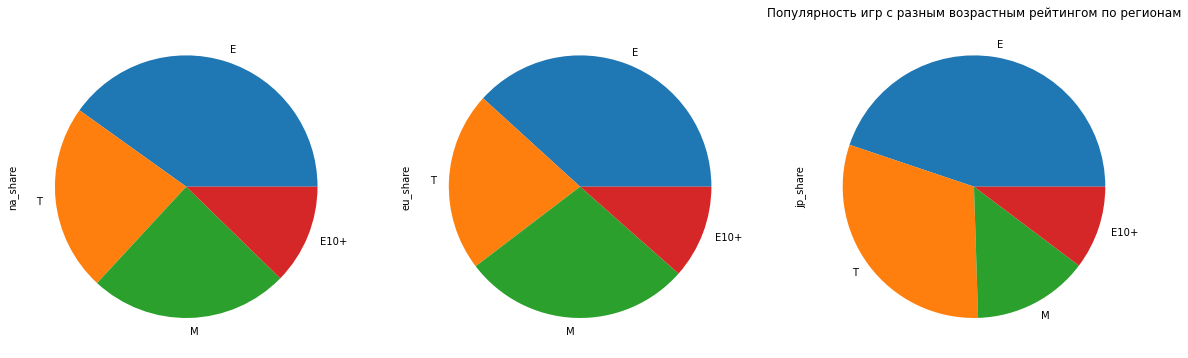

In [77]:
#построение круговых диаграмм
total_df_rating = jp_df_rating.copy()
total_df_rating ['count'] = na_df_rating['share']
total_df_rating ['sum'] = eu_df_rating['share']
total_df_rating = total_df_rating.query('index != ("unknown", "AO", "EC")')
total_df_rating.rename(columns = {'count' : 'na_share', 'sum' : 'eu_share', 'share' : 'jp_share'}, inplace = True)
total_df_rating.plot(figsize=(20, 20), kind='pie', subplots=True, legend=False)
plt.title('Популярность игр с разным возрастным рейтингом по регионам');

В Северной Америке и Европе лучше всего продаются игры с рейтингом «Everyone». Также пользуются большой популярностью игры с рейтингами «Mature» (от 17 лет) и «Teen». В Японии также по продажам лидируют игры с рейтингом «Everyone» и их доля среди всех проданных игр значительно выше, чем в других регионах, также выделяется сегмент игр с рейтенгом «Teen». Игры с рейтингом «Mature» (от 17 лет) в Японии продаются хуже, чем в среднем по миру.

## Проверка гипотез

### Сравнение пользовательских рейтингов платформ Xbox One и PC

Проанализируем пользовательские рейтинги игр на платформах XOne и PC. Расчитаем средний пользовательский рейтинг для каждой из платформ, а также  его дисперсию и стандартное отклонение для понимания картины распределения значений относительно среднего.

Для проведения более качественного анализа будем использовать игры с рейтингом не равным 0, это пропущенные значения.

In [78]:
#расчет среднего, дисперсии и стандартного отклонения
df_agg_platform = df_actual.query('user_score != 0').groupby(['platform']).agg({'user_score': ['mean', 'var', 'std']})
df_agg_platform.columns = ["_".join(a) for a in df_agg_platform.columns.to_flat_index()]
df_agg_platform.sort_values(by = 'user_score_mean', ascending = False, inplace = True)
df_agg_platform

,user_score_mean,user_score_var,user_score_std
platform,,,
PS,8.233333,0.863333,0.929157
PS2,7.654869,1.693463,1.301331
GBA,7.648889,2.055903,1.433842
GC,7.595652,1.867219,1.366462
XB,7.492665,2.288674,1.512836
PSV,7.336364,1.891767,1.375415
PSP,7.228266,1.505461,1.226972
DS,7.038835,2.183080,1.477525
PC,7.001913,2.311159,1.520250


Исходя из полученных данных можно предположить, что пользовательский рейтинг игр на платформе PC выше, чем на платформе XOne. Исходя из этого сформулируем нулевую и альтернативную гипотезы.

Нулевая гипотеза:

**Между пользовательскими рейтингами игр на платформах XOne и PC нет ожидаемого различия.**

Альтернативная гипотеза:

**Средний пользовательский рейтинг игр на платформе PC отличается от рейтинга игр на платформе XOne.**

Чтобы проверить выдвинутое предположение проведем статстический тест для двух генеральных совокупностей по взятым из них выборкам. Выборку с рейтингами игр на платформе XOne поместим в user_score_XOne, на платформе PC - в user_score_PC. Уровень значимости для теста определим пороговым значением 5%. Основываясь на предположении альтернативной гипотезы (PC != XOne) установим двусторонний критерий значимости. Применим метод scipy.stats.ttest_ind.

In [79]:
#подготовка выборок
user_score_XOne = df_actual.query('platform == "XOne" & user_score != 0')['user_score'].to_numpy()
user_score_PC = df_actual.query('platform == "PC"& user_score != 0')['user_score'].to_numpy()


In [80]:
#проведение статистического теста, расчет p-значения
alpha_platform = 0.05
results_platform = st.ttest_ind(user_score_XOne, user_score_PC)
'p-значение:', results_platform.pvalue

('p-значение:', 0.00011027930033672225)

Известно, что чем меньше p-значение, тем больше определенность в том, что нулевая гипотеза является ложной, и что мы нашли подлинный эффект. Приходим к выводу, что получить настолько малое p-значения в рамках нулевой гипотезы вряд ли возможно. Отвергаем нулевую гипотезу.

По итогам проведения теста известно, что средние пользовательские рейтинги игр на платформе PC и на платформе XOne отличаются. Удостоверимся в том, что выше рейтинг на платформе PC.

In [81]:
#проверка истинности альтернативы
results_platform.pvalue / 2 < alpha_platform and user_score_XOne.mean() < user_score_PC.mean()

True

### Сравнение пользовательских рейтингов жанров Action и Sports

Проанализируем пользовательские рейтинги игр жанров Action и Sports. Расчитаем средний пользовательский рейтинг для каждого жанра, а также его дисперсию и стандартное отклонение для понимания картины распределения значений относительно среднего.

Для проведения более качественного анализа будем использовать игры с рейтингом не равным 0, это пропущенные значения.

In [82]:
#расчет среднего количества, дисперсии и стандартного отклонения
df_agg_genre = df_actual.query('user_score != 0').groupby(['genre']).agg({'user_score': ['mean', 'var', 'std']})
df_agg_genre.columns = ["_".join(a) for a in df_agg_genre.columns.to_flat_index()]
df_agg_genre.sort_values(by = 'user_score_mean', ascending = False, inplace = True)
df_agg_genre

,user_score_mean,user_score_var,user_score_std
genre,,,
Role-Playing,7.555198,1.167579,1.080546
Platform,7.265375,2.307969,1.519200
Fighting,7.259189,1.928384,1.388663
Strategy,7.197902,2.756206,1.660183
Adventure,7.149648,2.597208,1.611586
Puzzle,7.140984,2.353513,1.534116
Simulation,7.064650,2.595775,1.611141
Action,7.034637,1.983899,1.408509
Shooter,7.014659,2.348989,1.532641


Учитывая размер стандартного отклонения (1,4 - 1,6) разница между средними значениями пользовательских рейтингов игр жанра Action (7,0) и Sports (6,9) кажется не существенной. Можно предположить, что пользовательские рейтинги игр жанров Action и Sports равны между собой. Исходя из этого сформулируем нулевую и альтернативную гипотезы.

Нулевая гипотеза:

**Средние пользовательские рейтинги игр жанра Action и жанра Sports равны между собой.**

Альтернативная гипотеза:

**Средние пользовательские рейтинги игр жанра Action и жанра Sports отличаются.**

Чтобы проверить выдвинутое предположение проведем статстический тест для двух генеральных совокупностей по взятым из них выборкам. Выборку с рейтингами игр жанра Action поместим в user_score_action, жанра Sports - user_score_sports. Уровень значимости для теста определим пороговым значением 5%. Основываясь на предположении альтернативной гипотезы (Action != Sports) установим двусторонний критерий значимости. Применим метод scipy.stats.ttest_ind.

In [83]:
#подготовка выборок
user_score_action = df_actual.query('genre == "Action" & user_score != 0')['user_score'].to_numpy()
user_score_sports = df_actual.query('genre == "Sports" & user_score != 0')['user_score'].to_numpy()

In [84]:
#проведение статистического теста, расчет p-значения
alpha_genre = 0.05
results_genre = st.ttest_ind(user_score_action, user_score_sports)
'p-значение:', results_genre.pvalue

('p-значение:', 0.04439818201010754)

Низкое p-значение дает основание отвергнуть нулевую гипотезу. Средние пользовательские рейтинги игр жанра Action и жанра Sports отличаются. Расширим статистический тест и убедимся, что средние пользовательские рейтинги игр жанра Action выше, чем жанра Sports.

In [85]:
#проверка истинности альтернативы
results_genre.pvalue / 2 < alpha_genre and user_score_sports.mean() < user_score_action.mean()

True

### Вывод

Проведены статстические тесты для двух генеральных совокупностей по взятым из них выборкам. Установлено, что существует высокая вероятность истинности следующих предположений:
- Средний пользовательский рейтинг игр на платформе PC выше, чем на платформе XOne.
- Средние пользовательские рейтинги игр жанра Action и жанра Sports отличаются.

## Общий вывод 

В ходе проведения анализа исторических данных о продажах игр выявлены критерии, позволяющие сделать ставку на потенциально популярный продукт:
- жанр игры - Action или Sports - эти жанры наиболее популярны в актуальном периоде во всех регионах мира. У игр жанра Action немного выше средние пользовательские оценки, его можно рассматривать как приоритетный.
- игровая платформа - PS4 и XOne - эти платформы в ближайшие годы будут занимать лидирующие позиции на рынке компьютерных игр.
- возрастная категория «Everyone» - такие игры наиболее популярны во всех регионах мира